# AthNLP 2024: Lab 1

# Table of Contents

---

### 1. [**Goal of this Lab**](#section:goal)

### 2. [**Preliminaries**](#section:preliminaries)

### 3. [**Part 1:Word Embeddings**](#section:word_embedds)

- #### [**Text Normalisation**](#section:Text_normalisation)

### 4. [**Part 2: Multilayer Perceptron & Sentiment Classifier**](#section:mlp_pt1)

- #### [**Train & Test data**](#section:train_test_split)

- #### [**Exercise 1 - Forward function & fully connected stack**](#section:exercise_1)

- #### [**Exercise 2 - Sentiment prediction**](#section:exercise_2)

### 4. [**Part 3: BERT embeddings**](#section:BERT)


### 8. [**Conclusion**](#section:conclusion)

### 9. [**Acknowledgements**](#section:acknowledgements)


<a name="section:goal"></a>

# Goal of this Lab


The aim of this lab is to introduce some fundamental concepts and methodologies that will get you
started on your NLP beginner-to-expert journey! To be more specific, today we will initially explain how
linguistic content is broken down and processed, while in the latter parts we will also be building
our own Neural model architecture, a Multi-Layer Perceptron (MLP) model, which we will use to
classify the sentiment of a sentence! In short, this lab will be split into three parts.

- Text & Word Embeddings
- MLP for sentiment classification with custom word embeddings
- MLP for sentiment classification with BERT embeddings


<a name="section:preliminaries"></a>

# Preliminaries


Let's begin by loading all our libraries. This might take a second.


In [ ]:
!wget https://raw.githubusercontent.com/athnlp/athnlp-labs-2024/main/data/imdb_dataset.csv -O imdb_dataset.csv

!pip install datasets ipdb evaluate

%load_ext rich

In [ ]:
import ipdb


import nltk
nltk.download('punkt')


from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


from pandas import read_csv
from sklearn.model_selection import train_test_split

import re
import torch
import torch.nn as nn
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification


import datasets
from tqdm.notebook import tqdm


seed = 2024


<a name="section:word_embedds"></a>

# Word Embeddings


This section will tackle text; namely how to process text in order for it to be fit for model
consumption. This is usually done through a process called **tokenisation** (or tokenization with
the American spelling system), where text is broken down into smaller units (can range from individual
words to punctuation marks).

These individual units are then mapped, with each unit having it's own
unique identifying "fingerprint" or their **embedding**. Embeddings are uually a list of either
floats or integers, which are mapped unto each unit. It is important to explain that an
embedding is not exactly akin to an index to a dictionary. While yes, each word embedding will
correspond to a unit of speech, word embeddings are created in a way that also tends to denote
similarities in meaning: words with high pairwise similarity in embeddings should also denote
semantic similarity.

To explain how this process works, run the next cell.


In [ ]:
toy_data = [
    "Word embed£££ings are a type of word repres$$@£entation that allows for           word!!!s to be represented as individual vectors in a continuous vECTor space.",
    "Every word is     map!!!!ped to one vecTOR and the ve$$@$$@ctor values are learned in a way that resembles a neu$$@ral network,      so the vectors capture many subtle linguistic properties.",
    "Vectors can indicate the similarity      bet,,ween WorDs, and be used to derive rela!!!!!!!tionships between Words.",
    "But vectors can also be used to map for semantic and contextual similarities between words.",
    "Word embeDDings can be extra!!cted from      large corpuses of text, although bigger is not always better, as      text quality can impact on embeDDings!",
]


Let's assume that the above text is perfect as is. We now need to take the text and break it down
into the aforementioned units of speech. Run the below cells to do this through an off-the-shelf
package (don't worry, we'll be doing our own tokenisation soon!).


In [ ]:
# @title Off-the-shelf tokenization {"run":"auto","display-mode":"both"}
# @markdown Look at the before/after for each sentence from the `toy_data` list by changing the index below.

tokenized_sentences = [word_tokenize(sentence) for sentence in toy_data]

sentence_index = 1 # @param {"type":"integer"}

print("Before: ", toy_data[sentence_index])
print("After: ", tokenized_sentences[sentence_index])

Excellent, absolutely nothing wrong with the above, let's proceed to get the indibidual word
embeddings. For now, let's assume that the toy data we have is our sole corpus. To extract the word
embeddings, we will be using _Word2Vec_.

While we will not be covering Word2Vec extensively, you should read [this
paper](https://arxiv.org/pdf/1301.3781) if interested. In short, Word2Vec takes text tokens, and
aims to patterns of co-occurence of words in the text, which usually denote at least a contextual
similarity.

The context of each word is denoted by the so called **window**, how many tokens before and after
the model should take into account for each unit. Small windows means that each word has little
contextual knowledge, while large windows can often lessen the significance for each one unit in a corpus. The
**vector size** denotes the size / dimensionality of the resulting vector, which will serve at the
unique identifier for each word. For a full breakdown of the arguments [see here](https://radimrehurek.com/gensim/models/word2vec.html)


In [ ]:
model = Word2Vec(tokenized_sentences, vector_size=20, window=5, min_count=1, workers=4)
word_embeddings = model.wv

print(word_embeddings["word", "Word"])

<a name="section:Text_normalisation"></a>

# Text normalisation

So as expected, we have some issues here. The words _word_ and _Word_ are not treated as equal
based on their word embeddings not being the same. This is unacceptable.

To avoid issues like these, there needs to be some sort of cleaning, a **preprocessing** step,
where text is **normalised** into . Basically, text is messy, and for models to make associations
correctly between seemingly dissimilar strings, we need to format text in a way that allows for an "Apples to apples" comparison.


In [ ]:
# @title Tokenization after normalisation {"run":"auto","display-mode":"both"}
# @markdown Look at the before/after for each sentence from the `toy_data` list by changing the index below.


def normalise_text(text):
    # Remove special characters manually
    cleaned_text = "".join(char for char in text if char.isalnum() or char.isspace())
    # Remove extra spaces
    cleaned_text = " ".join(cleaned_text.split())
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text


def normalise_dataset(dataset):
    cleaned_data = [normalise_text(sentence) for sentence in dataset]
    # return cleaned data
    return cleaned_data


cleaned_data = normalise_dataset(toy_data)
clean_tokenized_sentences = [word_tokenize(sentence) for sentence in cleaned_data]

sentence_index = 1 # @param {"type":"integer"}

print("Before: ", toy_data[sentence_index])
print("Tokenised: ")
print(tokenized_sentences[sentence_index])
print("Normalised+Tokenised: ")
print(clean_tokenized_sentences[sentence_index])

So far so good. Let's run the next cell and feel free to explore the embeddings for a given word!


In [ ]:
# @title Explore word embeddings {"run":"auto","vertical-output":true,"display-mode":"both"}
# @markdown View the word embeddings a word

model = Word2Vec(tokenized_sentences, vector_size=20, window=5, min_count=1, workers=4)
word_embeddings = model.wv

word_to_print = "word" # @param {"type":"string"}

print(word_embeddings[word_to_print])

<a name="section:mlp_pt1"></a>

# Multi-layer Perceptrons and Sentiment classification

Just as a reminder from the lecture, this is what a Multilayer Perceptron should look like (picture taken from [here](https://austingwalters.com/classify-sentences-via-a-multilayer-perceptron-mlp/)).

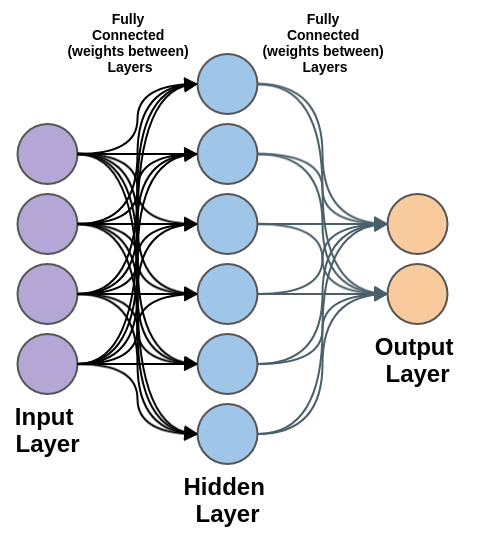

In this section, you will be building the fully conneted hidden layers, how exciting!

before we begin our process, we need to load our data.


In [ ]:
data_imdb = read_csv("imdb_dataset.csv")
data_imdb.head()

As we can see, the text is in need for some normalisation. Run the following to do so.

In [ ]:
def normalise_data_imdb(sentence: str):
    # Combine all regex operations into one
    sentence = re.sub(
        r'[!#?,.:";/>\*\(\)]', " ", sentence
    )  # Remove punctuation and specified chars
    sentence = re.sub(r"\n", " ", sentence)  # Replace newline characters with a space
    sentence = re.sub(r" +", " ", sentence)  # Remove multiple spaces
    sentence = re.sub(r"\S*<br\S*", "", sentence)  # Remove tokens containing "<br"
    sentence = sentence.lower()  # Convert to lowercase
    sentence = " ".join(sentence.split())
    # Return the cleaned sentence, removing any leading or trailing spaces
    return sentence.strip()

cleaned_data_imdb = data_imdb
cleaned_data_imdb["review"] = data_imdb["review"].apply(lambda x: normalise_data_imdb(x))
cleaned_data_imdb["review"]


So now that our data is normalised, we need to create a vocabulary of each unique individual tokenised unit both for our corpus text, but also our responses.



In [ ]:
unique_words = {word for sentence in cleaned_data_imdb["review"] for word in sentence.split(" ")}
unique_responses = set(cleaned_data_imdb["sentiment"])

vocab = {word: idx for idx, word in enumerate(unique_words)}
vocab_response = {response: idx for idx, response in enumerate(unique_responses)}

# We'll need this for later
voc_size = len(unique_words)

print(list(vocab.items())[0:4], list(vocab_response.items()))

<a name="section:train_test_split"></a>

# Train & Test data

So now that we have our dictionaries for both our text tokens and our responses (otherwise known as **labels**), we need to split our corpus into our training and testing set.

This is standard practice. The intuition is that while we want to train our model with a large corpus of data, our model can become **too** good at recognising patterns in our corpus, and then fail when employed in previously unseen data. This phenomenon is called **overfitting**, more formally referred to as the model's inability to generalise. An overfitted model essentially means that our model has learned to solve a corpus by looking at patterns of the words contained to such a level that it will not work when taken outside of that context.

As such, the reason as to why we split the data into sets is to train on one, and once a training "round" is over, we can test performance on a unseen data. In the code chunk below we will be splitting our dataset into a train set (80% of the data), and a test set (20% of the data).



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    cleaned_data_imdb["review"],
    cleaned_data_imdb["sentiment"],
    test_size=0.2,
    random_state=seed,
    shuffle=True,
    stratify=cleaned_data_imdb["sentiment"],
)


Let's check our data to fully understand what we just did.



In [ ]:
# @title View the split data (training)
# @markdown Change the index to view that example

index = 0 # @param {"type":"integer"}


print("x_train: ", x_train[index])
print("y_train: ", y_train[index])


So now we have our *tokens* split as part of the x_train and x_test (train and test corpus respectively), and our *labels* as part of the y_train and y_test. Great, so for every x we must make a model that predicts y, easy peasy.

Below we'll set up a few functions that we'll use later in our models to extract the identifier of each word. We'll use this later, but the functions should be self evident.

In [ ]:
# Extracts the index for each token in a normalised sentence
def tokenize_sentence(sentence: str) -> list[int]:
    return [vocab[word] for word in sentence.split(" ")]

# Extracts the index of a label
def tokenize_response(response: str) -> int:
    return vocab_response[response]


And now it's time to finally build our model. To begin with, we'll provide you with some of our *hyperparameters*. These are little aspects of configurability with our soon-to-be-built model. For now, just run these, although you can (and should) ask questions here about what each aspect does!

In [ ]:
dropout_prob = 0.3
embedding_dim = 32 # This might be important in the next block!
num_classes = 2
hidden_size_l1 = 32 # This might be important in the next block!
hidden_size_l2 = 32 # This might be important in the next block!
hidden_size_l3 = 32 # This might be important in the next block!
num_epochs = 6


<a name="section:exercise_1"></a>

# Exercise 1- Forward function & fully connected stack

And now finally, time to implement some code!

What we would like you to do is to fill the forward and __init__ functions in the nn.Module. Things to remember here.

The **__init__** function should instantiate your stack of layers

- **__init__** that will instantiate the stack of layers and activation functions (e.g., Linear, ReLu, dropout, etc.).
- **forward**: the forward pass of the model. This will accept a batch of sentence embeddings from the dataset and return the logits for each element in the batch.

Remember that we need to use an embedding layer that is custom made...

**Init Hint 1** perhaps you might find some help [here](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html), [here](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), and [here](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)

**Init Hint 2** shape(size of vocabulary, size of embedding dimensions)!

**Forward Hint 1** input needs to be embedded...

**Forward Hint 2** we need to go many word embeddings to a single sentence embedding...

**Forward Hint 3** Extract & return the logits and you're done!

In [ ]:
# @title [Task]

import torch
import torch.nn as nn


class MLP(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_size_l1: int,
        hidden_size_l2: int,
        hidden_size_l3: int,
        output_dimensions: int,
        dropout: float,
    ):
        raise NotImplementedError()

    def forward(self, x):
        raise NotImplementedError()


Time to intantiate our model! If done correctly, the below shouldn't break

In [ ]:
mlp_model = MLP(
    vocab_size=voc_size,
    embedding_dim=embedding_dim,
    hidden_size_l1=hidden_size_l1,
    hidden_size_l2=hidden_size_l2,
    hidden_size_l3=hidden_size_l3,
    output_dimensions=num_classes,
    dropout=dropout_prob,
)


And now time to train! Rule of thumb is that the loss should start to decrease given a few epochs. The below chunk shouldn't take too long to run.

In [ ]:
from tqdm.notebook import tqdm


def train_model(model, x_train, y_train, optimizer, num_epochs):
    print("Num Params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
    print(model)

    model.train()

    for epoch in range(num_epochs):
        progress_bar = tqdm(
            total=len(x_train), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch"
        )

        total_loss = 0
        correct_predictions = 0

        for text, label in zip(x_train, y_train, strict=True):
            # Convert the text to a tensor
            text_tensor = torch.tensor(tokenize_sentence(text)).unsqueeze(0)
            # Convert the label to a tensor
            label_tensor = torch.tensor(tokenize_response(label)).unsqueeze(0)

            # Forward pass
            predictions = model(text_tensor)

            # Calculate the loss
            loss = torch.nn.functional.cross_entropy(predictions, label_tensor)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


            total_loss += loss.item()
            correct_predictions += predictions.argmax(dim=-1).eq(label_tensor).sum().item()

            progress_bar.set_postfix(
                {
                    "loss": total_loss / (progress_bar.n + 1),
                    "micro_accuracy": correct_predictions / (progress_bar.n + 1),
                }
            )
            # Increment the progress bar
            progress_bar.update(1)

        # Close the progress bar at the end of each epoch
        progress_bar.close()

NUM_EXAMPLES = 1000

optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)

train_model(mlp_model, x_train[:NUM_EXAMPLES], y_train[:NUM_EXAMPLES], optimizer, num_epochs)

Cool, so we got our loss to go down, this must mean that our model is perfect to be used in the wild right? Let's just run a quick validation check with our test sample.

Remember, the test loop is practically the same as the train loop, we do a forward pass, although there's no gradient optimisation from the loss obtained as we do not want to actively train on the test set (that would be cheating!).

In [ ]:
@torch.inference_mode()
def eval_model(model, x_test, y_test):
    mlp_model.eval()

    progress_bar = tqdm(
        total=len(x_test), desc=f"Testing", unit="batch"
    )

    total_loss = 0
    correct_predictions = 0

    for text, label in zip(x_train, y_train, strict=True):
        # Convert the text to a tensor
        text_tensor = torch.tensor(tokenize_sentence(text)).unsqueeze(0)
        # Convert the label to a tensor
        label_tensor = torch.tensor(tokenize_response(label)).unsqueeze(0)

        # Forward pass
        predictions = model(text_tensor)

        # Calculate the loss
        loss = torch.nn.functional.cross_entropy(predictions, label_tensor)

        # Backward pass missing!

        total_loss += loss.item()
        correct_predictions += predictions.argmax(dim=-1).eq(label_tensor).sum().item()

        progress_bar.set_postfix(
            {
                "loss": total_loss / (progress_bar.n + 1),
                "micro_accuracy": correct_predictions / (progress_bar.n + 1),
            }
        )
        progress_bar.update(1)  # Increment the progress bar

    progress_bar.close()

NUM_EXAMPLES = 1000
eval_model(mlp_model, x_test[:NUM_EXAMPLES], y_test[:NUM_EXAMPLES])


<a name="section:exercise_2"></a>

# Exercise 2 - Sentiment prediction

So, now that our model seemingly runs, let's try to put it in practice, let's predict the sentiment of a sentence! An example is given below, but you can change the string to whatever you'd like (within reason)

In [ ]:
sentence = "I hate this move it's the worst movie I have ever seen"


So now we want to predict the sentiment of the sentence. Your task is to build the function that will do so.

This can be done in a number of steps, but generally we want to:

- Tensorise the tokenised sequence of the text
- Extract the probability of a prediction...
- Something something **argmax**
- Something something use the reversed response dictionary that we have calculated for *no* reason
- Return the correct prediction




In [ ]:
# @title [Task]

def predict_sentiment(
    text: str, model: nn.Module, reversed_response_dict: dict
) -> tuple[str, float]:
    raise NotImplementedError()

In [ ]:
normalised_sentence = normalise_data_imdb(sentence)

reversed_response_dict = {idx: response for response, idx in vocab_response.items()}

# Exercise 2 - Sentiment prediction_imdb(sentence)
predict_sentiment(normalised_sentence, mlp_model, reversed_response_dict)

<a name="section:BERT"></a>

# Pretrained Models & BERT

So we have managed to train a model, that's great! However, our performance is not amazing, and the time that a model takes to train is seemingly too long. So how can we improve upon this process? There's two main ways: improving upon the embeddings, and improving upon training speed.

While the embeddings that we constructed are seemingly ok, we are limited by our corpus of choice (our dataset). Wouldn't it be great if we could somehow use a model that has already been trained on, let's say, a very sizeable chunk of the internet? What about training on more than one example at a time?

Introducing **pretrained model**, and namely BERT! BERT stand for Bidirectional Encoder Representations from Transformers (paper [here](https://arxiv.org/abs/1810.04805)). BERT is a language representation model whose architecture has led to the boom of the NLP space from 2018 onwards.While you will hear more about transformers in later labs, today we want to show you how the choice of backbone models can greatly expedite and optimise our process.

TL;DR use BERT to transform our word embeddings in a very straightforward way. This takes away from needing to preprocess manually, while also having a greatly expanded context.





In [ ]:
# @title Convert our data to work with Hugging Face trainer

import datasets
import pandas as pd


def get_raw_data_with_same_splits(
    x_df: pd.DataFrame, y_df: pd.DataFrame
) -> pd.DataFrame:
    # Merge the two dataframes into one
    df = pd.concat([x_df, y_df], axis="columns")

    # re-load the raw data
    raw_data = read_csv("imdb_dataset.csv")

    # Use the indices from one df and get the raw data from the other
    return raw_data.loc[df.index, raw_data.columns]


dataset = (
    datasets.DatasetDict({
        "train": datasets.Dataset.from_pandas(
            get_raw_data_with_same_splits(x_train, y_train)
        ),
        "test": datasets.Dataset.from_pandas(
            get_raw_data_with_same_splits(x_test, y_test)
        ),
    })
    .remove_columns("__index_level_0__")
    .rename_column("review", "text")
    .rename_column("sentiment", "label")
    .cast_column("label", datasets.ClassLabel(names=["negative", "positive"]))
)

dataset


Remember how much effort we put into tokenising and preprocessing? Try running the lines below...

In [ ]:
# From: https://huggingface.co/google/bert_uncased_L-4_H-256_A-4
pretrained_model_name = "google/bert_uncased_L-2_H-128_A-2"


tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)


sentence = "I love this move it's best thing I have ever seen"
tokenizer.tokenize(sentence)


You will learn more about the below lines in the next lab, but we'll explain briefly what they do. Basically, every sentence can be of different lengths right? However, when we **torch our data**, the result is a matrix whose dimensions have to be to be constant across examples.

What we are doing here is **truncation**, the process of "filling" all the rows with a signifier that tells the model to pay no attention to these new "empty" tokens, while also shaping our data to the form that we need it to be in.

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], max_length=512, truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True).with_format("torch")

tokenized_dataset


The below lines are *extremely important*. Remember how our model took hours to train? That is because we were training with one example at a time, which we needed to do due to the uneven length of the torched data. However, now that our input data is fixed in size, we can **batch**!

Batching data essentially means processing multiple examples at a time that are handled by parallel processes. A batch size of 8 will mean that we can process 8 examples at a time! The next line essentially should be self evident, although you'll learn more during the next fewl labs.

In [ ]:
batch_size = 64
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

The following line is a ready made "classification" model. That's right, it *can be this simple*

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name, num_labels=2)
model.to(device)

for param in model.bert.parameters():
    param.requires_grad = False
for param in model.parameters():
    param.data = param.data.contiguous()


In [ ]:
model

Setting our hyperparameters.

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(-1)
    return metric.compute(predictions=predictions, references=labels)

NUM_EXAMPLES = 1000

training_args = TrainingArguments(
    output_dir="test_trainer",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=1,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'].select(range(NUM_EXAMPLES)),
    eval_dataset=tokenized_dataset['test'].select(range(NUM_EXAMPLES)),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)



Let it rip!

In [ ]:
trainer.train()

In [ ]:
trainer.evaluate()